# Vectors on Maps

Some approaches to showing flow with vectors or streamlines on maps. 

In [84]:
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import cartopy.crs as ccrs

In [7]:
import geocat.comp as gc

In [10]:
stem = Path("/Volumes/Drudonna/cam5_1deg_release_amip/atm/proc/tseries/month_1")

ufil = stem / "cam5_1deg_release_amip.cam.h0.U.200101-201012.nc"

vfil = stem / "cam5_1deg_release_amip.cam.h0.V.200101-201012.nc"

psfil = stem / "cam5_1deg_release_amip.cam.h0.PS.200101-201012.nc"

uds = xr.open_dataset(ufil)
vds = xr.open_dataset(vfil)
psds = xr.open_dataset(psfil)

In [11]:
u = uds['U']
v = vds['V']
ps = psds['PS']

In [5]:
uclimo = u.mean(dim='time')
vclimo = v.mean(dim='time')

In [12]:
psclimo = ps.mean(dim='time')

In [17]:
# just another dataset for comparison
stem2 = Path("/Volumes/Drudonna/cam4_1deg_release_amip/atm/proc/tseries/month_1")
uds2 =  xr.open_dataset(stem2 / "cam4_1deg_release_amip.cam.h0.U.200011-201012.nc")
vds2 =  xr.open_dataset(stem2 / "cam4_1deg_release_amip.cam.h0.V.200011-201012.nc")
psds2 = xr.open_dataset(stem2 / "cam4_1deg_release_amip.cam.h0.PS.200011-201012.nc")

u2climo = uds2['U'].mean(dim='time')
v2climo = vds2['V'].mean(dim='time')
ps2climo = psds2['PS'].mean(dim='time')


In [19]:
#
# convert from hybrid sigma coordinate to single pressure level
#
plev = 200.  # Desired isobaric level in hPa
vplev = gc.interp_hybrid_to_pressure(vclimo, psclimo, uds['hyam'], uds['hybm'], new_levels=np.array([100. * plev]), lev_dim='lev')
vplev = vplev.squeeze(drop=True).load()
uplev = gc.interp_hybrid_to_pressure(uclimo, psclimo, uds['hyam'], uds['hybm'], new_levels=np.array([100. * plev]), lev_dim='lev')
uplev = uplev.squeeze(drop=True).load()

u2plev = gc.interp_hybrid_to_pressure(u2climo, ps2climo, uds2['hyam'], uds2['hybm'], new_levels=np.array([100. * plev]), lev_dim='lev')
v2plev = gc.interp_hybrid_to_pressure(v2climo, ps2climo, vds2['hyam'], vds2['hybm'], new_levels=np.array([100. * plev]), lev_dim='lev')
u2plev = u2plev.squeeze(drop=True).load()
v2plev = v2plev.squeeze(drop=True).load()

In [40]:
# cartopy doesn't do a good job dealing with longitude 0-360, so switch to -180-180:


def lonFlip(data):
    # NOTE: this assumes global values
    tmplon = data['lon']
    tmpdata = data.roll(lon=len(tmplon) // 2, roll_coords=True)
    lonroll = tmpdata['lon'].values
    if tmplon.min() >= 0:
        # flip to -180:180
        tmpdata = tmpdata.assign_coords({'lon': np.where(lonroll >= 180, lonroll - 360, lonroll)})
    else:
        # flip from -180:180 to 0:360
        tmpdata = tmpdata.assign_coords({'lon': ((lonroll + 360) % 360)})
    return tmpdata




In [41]:
uplev = lonFlip(uplev)
vplev = lonFlip(vplev)
u2plev = lonFlip(u2plev)
v2plev = lonFlip(v2plev)

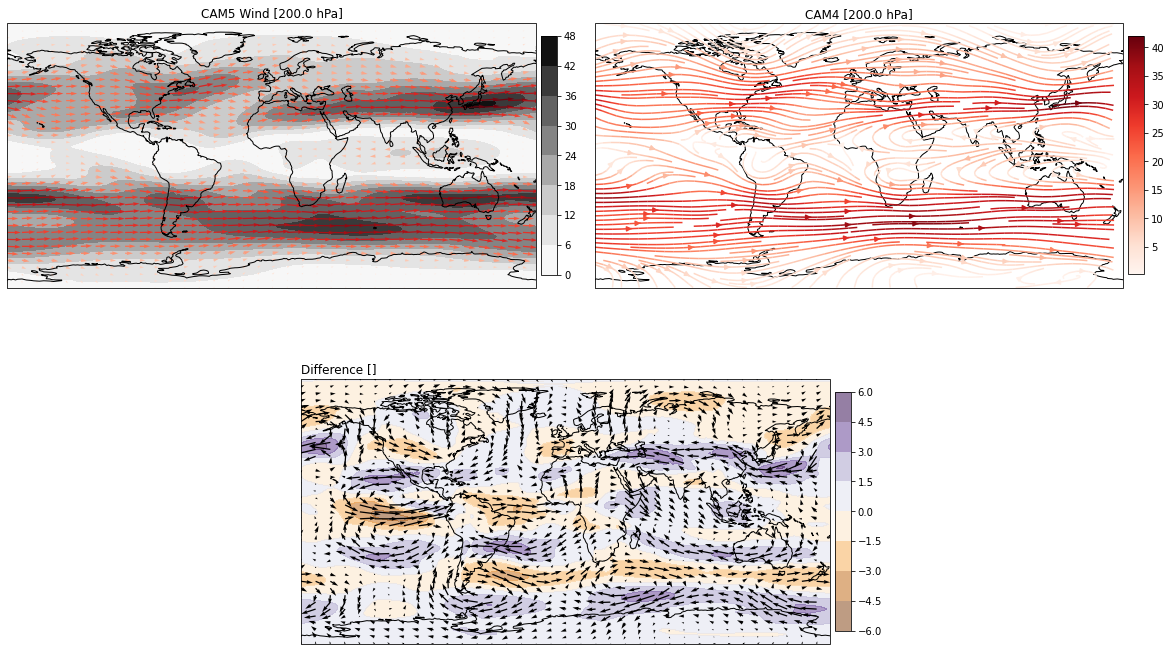

In [95]:

proj = ccrs.PlateCarree()
lons, lats = np.meshgrid(uplev['lon'], uplev['lat'])

fig = plt.figure(figsize=(20,12))

# LAYOUT WITH GRIDSPEC
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.25)
ax1 = plt.subplot(gs[0, :2], projection=proj)
ax2 = plt.subplot(gs[0, 2:], projection=proj)
ax3 = plt.subplot(gs[1, 1:3], projection=proj)

# too many vectors to see well, so prune by striding through data:
skip=(slice(None,None,5),slice(None,None,8))

# Candidate 1:
#  - contourf to show magnitude w/ colorbar
#  - vectors (colored or not) to show flow --> subjective (?) choice for how to thin out vectors to be legible
img1 = ax1.contourf(lons, lats, np.sqrt(uplev**2 + vplev**2), cmap='Greys', transform=ccrs.PlateCarree())
ax1.quiver(lons[skip], lats[skip], uplev[skip], vplev[skip], np.sqrt(uplev**2 + vplev**2).values[skip], transform=ccrs.PlateCarree(), cmap='Reds')
ax1.set_title(f"CAM5 Wind [{plev} hPa]")
## Add colorbar to Candidate 1:
cb_c1_ax = inset_axes(ax1,
                   width="3%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.01, 0.05, 1, 1),
                   bbox_transform=ax1.transAxes,
                   borderpad=0,
                   )
fig.colorbar(img1, cax=cb_c1_ax)

# Candidate 2:
#  - streamplot that shows the flow, colored to show magnitude (with colorbar)
strm = ax2.streamplot(lons, lats, u2plev.values, v2plev.values, density=2, color=np.sqrt(u2plev**2 + v2plev**2).values, cmap='Reds', transform=ccrs.PlateCarree())
ax2.set_title(f"CAM4 [{plev} hPa]")
cb_c2_ax = inset_axes(ax2,
                   width="3%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.01, 0.05, 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )
fig.colorbar(strm.lines, cax=cb_c2_ax)

# Showing the difference is probably easiest with a contour plot, 
# but then the anomalous circulation is hard to see, so could add vectors on top
udif = u2plev - uplev
vdif = v2plev - vplev

img3 = ax3.contourf(lons, lats, np.sqrt(uplev**2 + vplev**2)-np.sqrt(u2plev**2 + v2plev**2), transform=ccrs.PlateCarree(), norm=mpl.colors.TwoSlopeNorm(vmin=-5, vcenter=0.0, vmax=5), cmap='PuOr', alpha=0.5)
ax3.quiver(lons[skip], lats[skip], udif[skip], vdif[skip], transform=ccrs.PlateCarree())

# img3 = ax3.streamplot(lons, lats, udif.values, vdif.values, transform=ccrs.PlateCarree())
# img3 = ax3.barbs(lons[skip], lats[skip], udif.values[skip], vdif.values[skip], transform=ccrs.PlateCarree()) # does not look good for global data


ax3.set_title(f"Difference []", loc='left')
cb_d_ax = inset_axes(ax3,
                   width="3%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.01, 0.05, 1, 1),
                   bbox_transform=ax3.transAxes,
                   borderpad=0
                   )
fig.colorbar(img3, cax=cb_d_ax)

[a.coastlines() for a in [ax1,ax2,ax3]]

fig.savefig("/Users/brianpm/Desktop/vector_example.png", dpi=200, bbox_inches='tight')
